# Spoken Language Recognition Using Convolutional Neural Networks

_written by Joscha S. Rieber (Fraunhofer IAIS) in 2020_

## Training Environment

In [1]:
train = 'train'
test = 'test'

eng = 'english'
ger = 'german'
ita = 'italian'

languages = [eng, ger, ita]
categories = [train, test]

dataset_root_path = '../data/'
train_path = dataset_root_path + train

batch_size = 128
image_width = 500
image_height = 128

validation_split = 0.1
initial_learning_rate = 0.045

num_classes = len(languages)

model_file = dataset_root_path + 'model.h5'

In [39]:
from glob import glob
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# tf.keras.preprocessing.image.ImageDataGenerator
from tensorflow.keras.layers import Input, Concatenate
# tf.keras.layers.Input
# tf.keras.layers.Concatenate
from tensorflow.keras.optimizers import RMSprop
# tf.keras.optimizers.RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
# tf.keras.applications.inception_v3.InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
# tf.keras.callbacks.EarlyStopping
# tf.keras.callbacks.LearningRateScheduler

In [3]:
all_files = glob(train_path + '/*/*.png')

num_validation = len(all_files) * validation_split
num_train = len(all_files) - num_validation

validation_steps = int(num_validation / batch_size)
steps_per_epoch = int(num_train / batch_size)

print('Steps per Epoch: ' + str(steps_per_epoch))
print('Validation steps: ' + str(validation_steps))

Steps per Epoch: 337
Validation steps: 37


## Training Batch Generator Function

The following function loads the available images for training, shuffles them and serves them to Keras' training algorithm.

In [4]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=validation_split)
train_generator = image_data_generator.flow_from_directory(train_path, batch_size=batch_size, class_mode='categorical', target_size=(image_height, image_width), color_mode='grayscale', subset='training')
validation_generator = image_data_generator.flow_from_directory(train_path, batch_size=batch_size, class_mode='categorical', target_size=(image_height, image_width), color_mode='grayscale', subset='validation')

Found 43200 images belonging to 3 classes.
Found 4800 images belonging to 3 classes.


## Model definition

In [11]:
img_input = tf.keras.Input(shape=(image_height, image_width, 1))

img_conc = tf.keras.layers.Concatenate(axis=3, name='input_concat')([img_input, img_input, img_input])

model = tf.keras.applications.inception_v3.InceptionV3(input_tensor=img_conc, weights=None, include_top=True, classes=3)

model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 500, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_concat (Concatenate)     (None, 128, 500, 3)  0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 63, 249, 32)  864         ['input_concat[0][0]']

 batch_normalization_99 (BatchN  (None, 13, 60, 64)  192         ['conv2d_99[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_101 (Batch  (None, 13, 60, 64)  192         ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_104 (Batch  (None, 13, 60, 96)  288         ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_105 (Batch  (None, 13, 60, 32)  96          ['conv2d_105[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_116 (Batch  (None, 13, 60, 64)  192         ['conv2d_116[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_116 (Activation)    (None, 13, 60, 64)   0           ['batch_normalization_116[0][0]']
                                                                                                  
 conv2d_114 (Conv2D)            (None, 13, 60, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_117 (Conv2D)            (None, 13, 60, 96)   55296       ['activation_116[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 6, 29, 288)  0           ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 6, 29, 768)   0           ['activation_120[0][0]',         
                                                                  'activation_123[0][0]',         
                                                                  'max_pooling2d_6[0][0]']        
                                                                                                  
 conv2d_128 (Conv2D)            (None, 6, 29, 128)   98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_128 (Batch  (None, 6, 29, 128)  384         ['conv2d_128[0][0]']             
 Normaliza

                                                                  'activation_133[0][0]']         
                                                                                                  
 conv2d_138 (Conv2D)            (None, 6, 29, 160)   122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_138 (Batch  (None, 6, 29, 160)  480         ['conv2d_138[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_138 (Activation)    (None, 6, 29, 160)   0           ['batch_normalization_138[0][0]']
                                                                                                  
 conv2d_139 (Conv2D)            (None, 6, 29, 160)   179200      ['activation_138[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 6, 29, 160)   0           ['batch_normalization_148[0][0]']
                                                                                                  
 conv2d_149 (Conv2D)            (None, 6, 29, 160)   179200      ['activation_148[0][0]']         
                                                                                                  
 batch_normalization_149 (Batch  (None, 6, 29, 160)  480         ['conv2d_149[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_149 (Activation)    (None, 6, 29, 160)   0           ['batch_normalization_149[0][0]']
          

                                                                                                  
 batch_normalization_159 (Batch  (None, 6, 29, 192)  576         ['conv2d_159[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_159 (Activation)    (None, 6, 29, 192)   0           ['batch_normalization_159[0][0]']
                                                                                                  
 conv2d_155 (Conv2D)            (None, 6, 29, 192)   147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_160 (Conv2D)            (None, 6, 29, 192)   258048      ['activation_159[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_164 (Conv2D)            (None, 6, 29, 192)   147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_168 (Conv2D)            (None, 6, 29, 192)   258048      ['activation_167[0][0]']         
                                                                                                  
 batch_normalization_164 (Batch  (None, 6, 29, 192)  576         ['conv2d_164[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_168 (Batch  (None, 6, 29, 192)  576         ['conv2d_168[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_170 (Batch  (None, 2, 14, 320)  960         ['conv2d_170[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_172 (Activation)    (None, 2, 14, 384)   0           ['batch_normalization_172[0][0]']
                                                                                                  
 activation_173 (Activation)    (None, 2, 14, 384)   0           ['batch_normalization_173[0][0]']
                                                                                                  
 activation_176 (Activation)    (None, 2, 14, 384)   0           ['batch_normalization_176[0][0]']
                                                                                                  
 activation_177 (Activation)    (None, 2, 14, 384)   0           ['batch_normalization_177[0][0]']
          

                                                                                                  
 activation_185 (Activation)    (None, 2, 14, 384)   0           ['batch_normalization_185[0][0]']
                                                                                                  
 activation_186 (Activation)    (None, 2, 14, 384)   0           ['batch_normalization_186[0][0]']
                                                                                                  
 batch_normalization_187 (Batch  (None, 2, 14, 192)  576         ['conv2d_187[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_179 (Activation)    (None, 2, 14, 320)   0           ['batch_normalization_179[0][0]']
                                                                                                  
 mixed9_1 

In [12]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=initial_learning_rate, clipvalue=2.0), loss='categorical_crossentropy', metrics=['accuracy'])

## Training

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)

In [14]:
def step_decay(epoch, lr):
    drop = 0.94
    epochs_drop = 2.0
    lrate = lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

learning_rate_decay = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [15]:
#model.add(tf.keras.layers.Dense(3, activation = 'softmax'))
history = model.fit(train_generator, validation_data=validation_generator, epochs=60, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, callbacks=[early_stopping, learning_rate_decay])


Epoch 1: LearningRateScheduler setting learning rate to 0.04500000178813934.
Epoch 1/60
337/337 [==============================] - 4800s 14s/step - loss: 1.5608 - accuracy: 0.3679 - val_loss: 76.4125 - val_accuracy: 0.3321 - lr: 0.0450

Epoch 2: LearningRateScheduler setting learning rate to 0.042300001680850983.
Epoch 2/60
337/337 [==============================] - 4769s 14s/step - loss: 0.8268 - accuracy: 0.6314 - val_loss: 10.5556 - val_accuracy: 0.3767 - lr: 0.0423

Epoch 3: LearningRateScheduler setting learning rate to 0.03976200073957443.
Epoch 3/60
337/337 [==============================] - 4773s 14s/step - loss: 0.5080 - accuracy: 0.8009 - val_loss: 34.5522 - val_accuracy: 0.3809 - lr: 0.0398

Epoch 4: LearningRateScheduler setting learning rate to 0.03513370451182127.
Epoch 4/60
337/337 [==============================] - 4770s 14s/step - loss: 0.3799 - accuracy: 0.8546 - val_loss: 1.4688 - val_accuracy: 0.6742 - lr: 0.0351

Epoch 5: LearningRateScheduler setting learning rat

In [24]:
model.save(model_file)

## Plot Training History for Accuracy

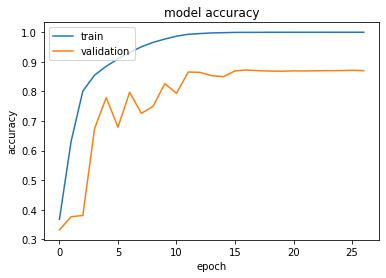

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Model Evaluation Environment


The following function loads the available images for evaluation

In [55]:
test_path = dataset_root_path + test

In [56]:
all_files = glob(test_path + '/*/*.png')

num_test = len(all_files)

evaluation_steps = int(num_test / batch_size)

print('Evaluation steps: ' + str(evaluation_steps))

Evaluation steps: 46


In [57]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
evaluation_generator = image_data_generator.flow_from_directory(test_path, batch_size=batch_size, class_mode='categorical', target_size=(image_height, image_width), color_mode='grayscale')

Found 6000 images belonging to 3 classes.


## Model Evaluation

In [58]:
from tensorflow.keras.models import load_model

In [59]:
model = tf.keras.models.load_model(model_file)

In [60]:
_, test_accuracy = model.evaluate(evaluation_generator, steps=evaluation_steps)

46/46 [==============================] - 103s 2s/step - loss: 0.6196 - accuracy: 0.9124


In [61]:
predict = model.predict(evaluation_generator)

# print the first 10 predictions
print(predict[:100])

47/47 [==============================] - 110s 2s/step
[[2.65013299e-14 4.02896170e-08 1.00000000e+00]
 [2.00838517e-29 1.64306090e-19 1.00000000e+00]
 [1.00000000e+00 1.11512820e-10 2.31083513e-10]
 [4.73915815e-01 5.26084125e-01 1.03630073e-08]
 [9.99983072e-01 5.60152369e-10 1.68779970e-05]
 [3.22415261e-03 9.96752501e-01 2.33707779e-05]
 [2.08843616e-04 9.99790967e-01 2.79428832e-07]
 [1.20358519e-26 5.53956135e-20 1.00000000e+00]
 [7.61347974e-06 7.66130004e-09 9.99992371e-01]
 [6.44458320e-10 1.00000000e+00 1.59858560e-09]
 [1.82118572e-14 1.00000000e+00 1.82887775e-15]
 [1.01494155e-16 1.00000000e+00 2.69357933e-16]
 [1.37123385e-17 1.00000000e+00 5.71445236e-18]
 [4.88710461e-10 1.00000000e+00 1.15852128e-11]
 [9.95421946e-01 4.57799947e-03 1.72093539e-08]
 [3.56793462e-05 9.99964356e-01 3.94493683e-12]
 [1.90081388e-11 8.37199450e-01 1.62800550e-01]
 [1.56584695e-12 1.00000000e+00 7.07310113e-11]
 [1.04060449e-09 1.00000000e+00 7.83463516e-10]
 [8.86434282e-06 9.99989152e-01 2.

In [ ]:
# Pick one image in test_path and predict it with the model
# Hint: use the function load_img from keras.preprocessing.image

import numpy as np

from tensorflow.keras.preprocessing.image import load_img

img = load_img(test_path + '/german/common_voice_de_17566978.mp3.png', color_mode='grayscale', target_size=(image_height, image_width))

# modify the image to make it fit the model based on the evaluation generator and image data generator
# Hint: use the function img_to_array from keras.preprocessing.image

from tensorflow.keras.preprocessing.image import img_to_array

img = img_to_array(img)
img = img.reshape((1, image_height, image_width, 1))
img = img.astype('float32')
img = img / 255.0

# predict the image with the model
# Hint: use the function predict from keras.models

prediction = model.predict(img)

# print the prediction

print(prediction)

In [35]:
print('Test accuracy: ' + str(round(test_accuracy * 100., 1)) + ' %')

Test accuracy: 91.2 %


Found 6000 images belonging to 3 classes.
47/47 [==============================] - 108s 2s/step


<AxesSubplot:>

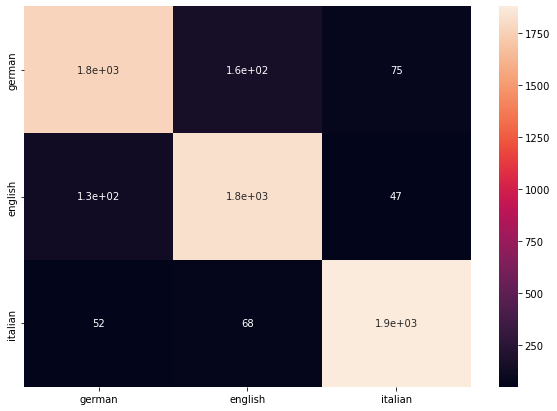

In [79]:
# visualize the confusion matrix of the model

from sklearn.metrics import confusion_matrix
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

import pandas as pd

# get the labels from the evaluation generator, shuffle=False
evaluation_generator = image_data_generator.flow_from_directory(test_path, batch_size=batch_size, class_mode='categorical', target_size=(image_height, image_width), color_mode='grayscale', shuffle=False)

labels = evaluation_generator.classes

# get the predictions from the model

predictions = model.predict(evaluation_generator)

# get the predicted labels

predicted_labels = np.argmax(predictions, axis=1)

# get the confusion matrix

cm = confusion_matrix(labels, predicted_labels)

# plot the confusion matrix

df_cm = pd.DataFrame(cm, index = [i for i in ['german', 'english', 'italian']],
                    columns = [i for i in ['german', 'english', 'italian']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)


Text(69.0, 0.5, 'True')

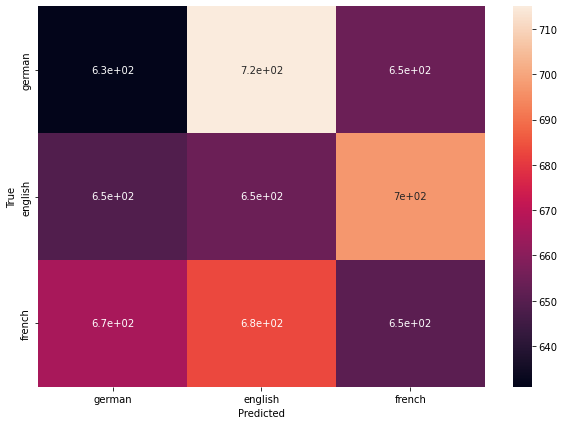

In [80]:
# plot the confusion matrix using tf.math.confusion_matrix
# Hint: use the function confusion_matrix from keras.metrics

